In [1]:
import numpy as np 
import pandas as pd 
import cv2
from matplotlib import pyplot as plt
import os
from subprocess import check_output
import cv2
from PIL import Image
import glob

In [3]:
trainLabels = pd.read_csv("../input/labels/trainLabels.csv")
print(trainLabels.head())

filelist = glob.glob('../input/bloodvessel/bloodvesselextraction/BloodVesselExtraction/*.jpeg')
##filelist = glob.glob('../input/diabetic-retinopathy-detection/*.jpeg')
np.size(filelist)

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1


500

In [4]:
img_data = []
img_label = []
img_r = 512
img_c = 512
for file in filelist:
    tmp = cv2.imread(file)
    tmp = cv2.resize(tmp,(img_r, img_c), interpolation = cv2.INTER_CUBIC)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
    img_data.append(np.array(tmp).flatten())
    tmpfn = file
    tmpfn = tmpfn.replace("../input/bloodvessel/bloodvesselextraction/BloodVesselExtraction/","")
    ##tmpfn = tmpfn.replace("../input/diabetic-retinopathy-detection/","")
    tmpfn = tmpfn.replace(".jpeg","")
    img_label.append(trainLabels.loc[trainLabels.image==tmpfn, 'level'].values[0])

In [5]:
data = pd.DataFrame({'img_data':img_data,'label':img_label})
data.sample(3)

,img_data,label
489,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0
267,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0
10,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbaa3cd9cf8>]],
      dtype=object)

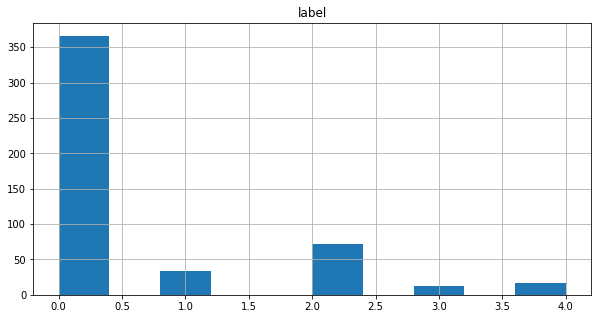

In [6]:
data[['label']].hist(figsize = (10, 5))

New Data Size: 800 Old Size: 400


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba91da5a20>]],
      dtype=object)

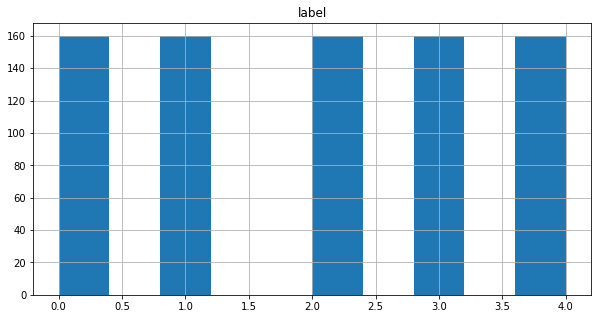

In [7]:
from sklearn.model_selection import train_test_split
X = data['img_data']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.utils import shuffle

data,label = shuffle(X_train,y_train, random_state=2)
train_data = pd.DataFrame({'data': data, 'label':label})
train_df = train_data.groupby(['label']).apply(lambda x: x.sample(160, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', train_data.shape[0])
train_df[['label']].hist(figsize = (10, 5))

In [8]:
X_train = train_df['data']
y_train = train_df['label']

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [9]:
X_train_resh = np.zeros([X_train.shape[0],img_r, img_c, 1])
for i in range (X_train.shape[0]-1):
    X_train_resh[i] = np.reshape(X_train[i], (img_r, img_c, 1))
    
X_test_resh = np.zeros([X_test.shape[0],img_r, img_c, 1])
for i in range (X_test.shape[0]-1):
    X_test_resh[i] = np.reshape(X_test[i], (img_r, img_c, 1))
print(X_test_resh.shape)

(100, 512, 512, 1)


In [10]:
from keras.utils import np_utils
nb_classes = 5
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Using TensorFlow backend.


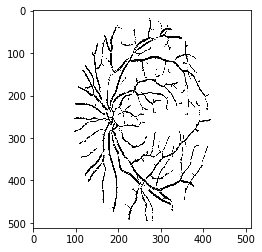

In [11]:
import matplotlib.pyplot as plt
import matplotlib

img=X_train_resh[100].reshape(img_r,img_c)
plt.imshow(img)
plt.imshow(img,cmap='gray')

In [12]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

input_layer = Input(shape=(512, 512, 1))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(6400, activation='relu')(x1)
x1 = Dense(3200, activation='relu')(x1)
x1 = Dense(1600, activation='relu')(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dense(800, activation='relu')(x1)
x1 = Dense(400, activation='relu')(x1)
x1 = Dense(200, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(5, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(6400, activation='relu')(x2)
x2 = Dense(3200, activation='relu')(x2)
x2 = Dense(1600, activation='relu')(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dense(800, activation='relu')(x2)
x2 = Dense(400, activation='relu')(x2)
x2 = Dense(200, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(5, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dense(6400, activation='relu')(x)
x = Dense(3200, activation='relu')(x)
x = Dense(1600, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(800, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(5, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 256, 256, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 128, 128, 64) 0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D

In [13]:
sgd = SGD(lr = 0.01, momentum=0.9, nesterov=False)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])
from keras.callbacks import ReduceLROnPlateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [14]:
history = model.fit(X_train_resh, [Y_train, Y_train, Y_train], validation_data=(X_test_resh, [Y_test, Y_test, Y_test]), epochs=200, batch_size=32, callbacks=[reduceLROnPlat])

Instructions for updating:
Use tf.cast instead.
Train on 800 samples, validate on 100 samples
Epoch 1/200
800/800 [==============================] - 25s 31ms/step - loss: 2.6911 - output_loss: 1.6307 - auxilliary_output_1_loss: 1.8527 - auxilliary_output_2_loss: 1.6820 - output_acc: 0.1762 - auxilliary_output_1_acc: 0.1825 - auxilliary_output_2_acc: 0.1775 - val_loss: 2.6455 - val_output_loss: 1.6709 - val_auxilliary_output_1_loss: 1.6388 - val_auxilliary_output_2_loss: 1.6098 - val_output_acc: 0.0100 - val_auxilliary_output_1_acc: 0.0400 - val_auxilliary_output_2_acc: 0.0400
Epoch 2/200
800/800 [==============================] - 11s 13ms/step - loss: 2.5838 - output_loss: 1.6170 - auxilliary_output_1_loss: 1.6098 - auxilliary_output_2_loss: 1.6130 - output_acc: 0.2100 - auxilliary_output_1_acc: 0.2125 - auxilliary_output_2_acc: 0.1787 - val_loss: 2.5872 - val_output_loss: 1.6211 - val_auxilliary_output_1_loss: 1.6187 - val_auxilliary_output_2_loss: 1.6014 - val_output_acc: 0.0400 - va

Epoch 17/200
800/800 [==============================] - 11s 13ms/step - loss: 2.4653 - output_loss: 1.6082 - auxilliary_output_1_loss: 1.3893 - auxilliary_output_2_loss: 1.4677 - output_acc: 0.2125 - auxilliary_output_1_acc: 0.4037 - auxilliary_output_2_acc: 0.3775 - val_loss: 2.5887 - val_output_loss: 1.6209 - val_auxilliary_output_1_loss: 1.6373 - val_auxilliary_output_2_loss: 1.5889 - val_output_acc: 0.0600 - val_auxilliary_output_1_acc: 0.1500 - val_auxilliary_output_2_acc: 0.0200

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.006399999558925629.
Epoch 18/200
800/800 [==============================] - 11s 13ms/step - loss: 2.3220 - output_loss: 1.5845 - auxilliary_output_1_loss: 1.1772 - auxilliary_output_2_loss: 1.2810 - output_acc: 0.2387 - auxilliary_output_1_acc: 0.5225 - auxilliary_output_2_acc: 0.4713 - val_loss: 2.4283 - val_output_loss: 1.6162 - val_auxilliary_output_1_loss: 1.3162 - val_auxilliary_output_2_loss: 1.3908 - val_output_acc: 0.0500 - val_auxilliary

800/800 [==============================] - 11s 13ms/step - loss: 1.5120 - output_loss: 1.4888 - auxilliary_output_1_loss: 0.0305 - auxilliary_output_2_loss: 0.0468 - output_acc: 0.3100 - auxilliary_output_1_acc: 0.9962 - auxilliary_output_2_acc: 0.9888 - val_loss: 2.9181 - val_output_loss: 1.6608 - val_auxilliary_output_1_loss: 2.2888 - val_auxilliary_output_2_loss: 1.9020 - val_output_acc: 0.0200 - val_auxilliary_output_1_acc: 0.5900 - val_auxilliary_output_2_acc: 0.6400
Epoch 34/200
800/800 [==============================] - 11s 13ms/step - loss: 1.4712 - output_loss: 1.4468 - auxilliary_output_1_loss: 0.0369 - auxilliary_output_2_loss: 0.0443 - output_acc: 0.3463 - auxilliary_output_1_acc: 0.9862 - auxilliary_output_2_acc: 0.9888 - val_loss: 3.1990 - val_output_loss: 1.6390 - val_auxilliary_output_1_loss: 2.2523 - val_auxilliary_output_2_loss: 2.9479 - val_output_acc: 0.4000 - val_auxilliary_output_1_acc: 0.5600 - val_auxilliary_output_2_acc: 0.5000
Epoch 35/200
800/800 [===========

800/800 [==============================] - 11s 13ms/step - loss: 1.4600 - output_loss: 1.4553 - auxilliary_output_1_loss: 0.0091 - auxilliary_output_2_loss: 0.0064 - output_acc: 0.3400 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 3.4613 - val_output_loss: 1.5201 - val_auxilliary_output_1_loss: 3.3277 - val_auxilliary_output_2_loss: 3.1433 - val_output_acc: 0.6100 - val_auxilliary_output_1_acc: 0.6100 - val_auxilliary_output_2_acc: 0.6100
Epoch 50/200
800/800 [==============================] - 11s 14ms/step - loss: 1.5203 - output_loss: 1.5149 - auxilliary_output_1_loss: 0.0078 - auxilliary_output_2_loss: 0.0103 - output_acc: 0.3050 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 3.3333 - val_output_loss: 1.6256 - val_auxilliary_output_1_loss: 3.0208 - val_auxilliary_output_2_loss: 2.6714 - val_output_acc: 0.0600 - val_auxilliary_output_1_acc: 0.6100 - val_auxilliary_output_2_acc: 0.5800
Epoch 51/200
800/800 [===========

800/800 [==============================] - 11s 14ms/step - loss: 1.0750 - output_loss: 1.0730 - auxilliary_output_1_loss: 0.0030 - auxilliary_output_2_loss: 0.0036 - output_acc: 0.5463 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9975 - val_loss: 4.2680 - val_output_loss: 1.6896 - val_auxilliary_output_1_loss: 4.1930 - val_auxilliary_output_2_loss: 4.4017 - val_output_acc: 0.2100 - val_auxilliary_output_1_acc: 0.6100 - val_auxilliary_output_2_acc: 0.6300
Epoch 66/200
800/800 [==============================] - 11s 14ms/step - loss: 1.0180 - output_loss: 1.0120 - auxilliary_output_1_loss: 0.0107 - auxilliary_output_2_loss: 0.0092 - output_acc: 0.5637 - auxilliary_output_1_acc: 0.9975 - auxilliary_output_2_acc: 0.9975 - val_loss: 4.4757 - val_output_loss: 1.6979 - val_auxilliary_output_1_loss: 4.1858 - val_auxilliary_output_2_loss: 5.0734 - val_output_acc: 0.1100 - val_auxilliary_output_1_acc: 0.6600 - val_auxilliary_output_2_acc: 0.5100

Epoch 00066: ReduceLROnPlateau r

800/800 [==============================] - 11s 14ms/step - loss: 0.7662 - output_loss: 0.7646 - auxilliary_output_1_loss: 0.0028 - auxilliary_output_2_loss: 0.0027 - output_acc: 0.6775 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 4.0275 - val_output_loss: 1.5477 - val_auxilliary_output_1_loss: 3.8804 - val_auxilliary_output_2_loss: 4.3856 - val_output_acc: 0.3000 - val_auxilliary_output_1_acc: 0.6500 - val_auxilliary_output_2_acc: 0.6100
Epoch 82/200
800/800 [==============================] - 11s 13ms/step - loss: 0.5330 - output_loss: 0.5317 - auxilliary_output_1_loss: 0.0027 - auxilliary_output_2_loss: 0.0017 - output_acc: 0.7762 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 4.3419 - val_output_loss: 1.6273 - val_auxilliary_output_1_loss: 4.1465 - val_auxilliary_output_2_loss: 4.9020 - val_output_acc: 0.3600 - val_auxilliary_output_1_acc: 0.6500 - val_auxilliary_output_2_acc: 0.5800
Epoch 83/200
800/800 [===========

800/800 [==============================] - 11s 14ms/step - loss: 0.3381 - output_loss: 0.3363 - auxilliary_output_1_loss: 0.0031 - auxilliary_output_2_loss: 0.0028 - output_acc: 0.8750 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9975 - val_loss: 4.5937 - val_output_loss: 1.5326 - val_auxilliary_output_1_loss: 4.5885 - val_auxilliary_output_2_loss: 5.6153 - val_output_acc: 0.3800 - val_auxilliary_output_1_acc: 0.6200 - val_auxilliary_output_2_acc: 0.5400
Epoch 98/200
800/800 [==============================] - 11s 14ms/step - loss: 0.2443 - output_loss: 0.2430 - auxilliary_output_1_loss: 0.0025 - auxilliary_output_2_loss: 0.0020 - output_acc: 0.8987 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 5.1156 - val_output_loss: 2.0833 - val_auxilliary_output_1_loss: 4.5796 - val_auxilliary_output_2_loss: 5.5283 - val_output_acc: 0.5200 - val_auxilliary_output_1_acc: 0.6400 - val_auxilliary_output_2_acc: 0.5600
Epoch 99/200
800/800 [===========

800/800 [==============================] - 11s 13ms/step - loss: 0.1146 - output_loss: 0.1133 - auxilliary_output_1_loss: 0.0026 - auxilliary_output_2_loss: 0.0018 - output_acc: 0.9625 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 4.8465 - val_output_loss: 1.7499 - val_auxilliary_output_1_loss: 5.0340 - val_auxilliary_output_2_loss: 5.2882 - val_output_acc: 0.6500 - val_auxilliary_output_1_acc: 0.6100 - val_auxilliary_output_2_acc: 0.5900
Epoch 114/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0591 - output_loss: 0.0561 - auxilliary_output_1_loss: 0.0023 - auxilliary_output_2_loss: 0.0078 - output_acc: 0.9888 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 5.0670 - val_output_loss: 1.8352 - val_auxilliary_output_1_loss: 5.0075 - val_auxilliary_output_2_loss: 5.7652 - val_output_acc: 0.5800 - val_auxilliary_output_1_acc: 0.6100 - val_auxilliary_output_2_acc: 0.5600
Epoch 115/200
800/800 [=========

800/800 [==============================] - 11s 14ms/step - loss: 0.0097 - output_loss: 0.0083 - auxilliary_output_1_loss: 0.0028 - auxilliary_output_2_loss: 0.0018 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 5.9418 - val_output_loss: 2.5307 - val_auxilliary_output_1_loss: 5.2174 - val_auxilliary_output_2_loss: 6.1530 - val_output_acc: 0.6000 - val_auxilliary_output_1_acc: 0.5900 - val_auxilliary_output_2_acc: 0.5500

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.0001801439793780446.
Epoch 130/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0127 - output_loss: 0.0096 - auxilliary_output_1_loss: 0.0025 - auxilliary_output_2_loss: 0.0081 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 6.0096 - val_output_loss: 2.6450 - val_auxilliary_output_1_loss: 5.2114 - val_auxilliary_output_2_loss: 6.0040 - val_output_acc: 0.5700 - val_auxilliary_output_1_a

800/800 [==============================] - 11s 13ms/step - loss: 0.0069 - output_loss: 0.0059 - auxilliary_output_1_loss: 0.0019 - auxilliary_output_2_loss: 0.0017 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 6.2678 - val_output_loss: 2.9178 - val_auxilliary_output_1_loss: 5.3571 - val_auxilliary_output_2_loss: 5.8094 - val_output_acc: 0.5600 - val_auxilliary_output_1_acc: 0.5800 - val_auxilliary_output_2_acc: 0.5600
Epoch 146/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0070 - output_loss: 0.0056 - auxilliary_output_1_loss: 0.0027 - auxilliary_output_2_loss: 0.0019 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 6.2448 - val_output_loss: 2.9014 - val_auxilliary_output_1_loss: 5.3442 - val_auxilliary_output_2_loss: 5.8004 - val_output_acc: 0.5700 - val_auxilliary_output_1_acc: 0.5800 - val_auxilliary_output_2_acc: 0.5500
Epoch 147/200
800/800 [=========

Epoch 162/200
800/800 [==============================] - 11s 14ms/step - loss: 0.0072 - output_loss: 0.0054 - auxilliary_output_1_loss: 0.0028 - auxilliary_output_2_loss: 0.0032 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 6.3656 - val_output_loss: 2.9907 - val_auxilliary_output_1_loss: 5.3176 - val_auxilliary_output_2_loss: 5.9322 - val_output_acc: 0.5600 - val_auxilliary_output_1_acc: 0.5900 - val_auxilliary_output_2_acc: 0.5600
Epoch 163/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0081 - output_loss: 0.0057 - auxilliary_output_1_loss: 0.0018 - auxilliary_output_2_loss: 0.0064 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 6.2506 - val_output_loss: 2.8526 - val_auxilliary_output_1_loss: 5.3225 - val_auxilliary_output_2_loss: 6.0039 - val_output_acc: 0.5900 - val_auxilliary_output_1_acc: 0.5900 - val_auxilliary_output_2_acc: 0.5500
Epoch 164/200
800/

Epoch 179/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0076 - output_loss: 0.0062 - auxilliary_output_1_loss: 0.0028 - auxilliary_output_2_loss: 0.0017 - output_acc: 0.9975 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 6.6155 - val_output_loss: 3.1573 - val_auxilliary_output_1_loss: 5.3105 - val_auxilliary_output_2_loss: 6.2168 - val_output_acc: 0.5400 - val_auxilliary_output_1_acc: 0.5900 - val_auxilliary_output_2_acc: 0.5500
Epoch 180/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0065 - output_loss: 0.0050 - auxilliary_output_1_loss: 0.0022 - auxilliary_output_2_loss: 0.0028 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 0.9988 - val_loss: 6.4344 - val_output_loss: 2.9735 - val_auxilliary_output_1_loss: 5.3245 - val_auxilliary_output_2_loss: 6.2121 - val_output_acc: 0.6000 - val_auxilliary_output_1_acc: 0.5800 - val_auxilliary_output_2_acc: 0.5500
Epoch 181/200
800/

Epoch 196/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0058 - output_loss: 0.0046 - auxilliary_output_1_loss: 0.0027 - auxilliary_output_2_loss: 0.0015 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 6.5208 - val_output_loss: 3.0873 - val_auxilliary_output_1_loss: 5.2726 - val_auxilliary_output_2_loss: 6.1725 - val_output_acc: 0.5800 - val_auxilliary_output_1_acc: 0.5800 - val_auxilliary_output_2_acc: 0.5600
Epoch 197/200
800/800 [==============================] - 11s 13ms/step - loss: 0.0051 - output_loss: 0.0040 - auxilliary_output_1_loss: 0.0021 - auxilliary_output_2_loss: 0.0015 - output_acc: 0.9988 - auxilliary_output_1_acc: 0.9988 - auxilliary_output_2_acc: 1.0000 - val_loss: 6.6241 - val_output_loss: 3.1883 - val_auxilliary_output_1_loss: 5.2756 - val_auxilliary_output_2_loss: 6.1770 - val_output_acc: 0.5700 - val_auxilliary_output_1_acc: 0.5800 - val_auxilliary_output_2_acc: 0.5600
Epoch 198/200
800/

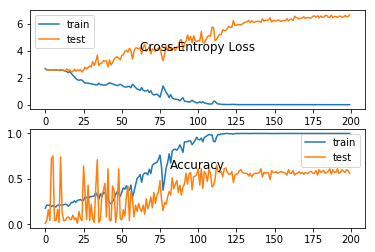

In [15]:
import matplotlib.pyplot as pyplot
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['output_acc'], label='train')
pyplot.plot(history.history['val_output_acc'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
pyplot.savefig("trainmetrics.png")

<Figure size 432x288 with 0 Axes>

In [16]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = model.predict(X_test_resh, batch_size = 32, verbose = True)

pred_Y_cat = np.argmax(pred_Y, -1)
#print(pred_Y_cat[0])

test_Y_cat = np.argmax(Y_test, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat[0])))
print(classification_report(test_Y_cat, pred_Y_cat[0]))

100/100 [==============================] - 1s 9ms/step
Accuracy on Test Data: 0.56%
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        75
           1       0.00      0.00      0.00         4
           2       0.21      0.44      0.29        16
           3       0.00      0.00      0.00         1
           4       0.25      0.25      0.25         4

   micro avg       0.56      0.56      0.56       100
   macro avg       0.25      0.27      0.25       100
weighted avg       0.63      0.56      0.59       100



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


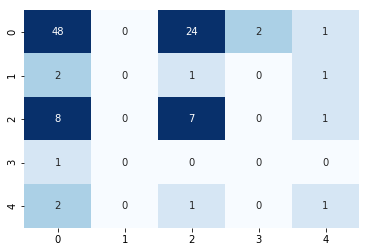

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat[0]), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_test_resh.shape[0]//16)

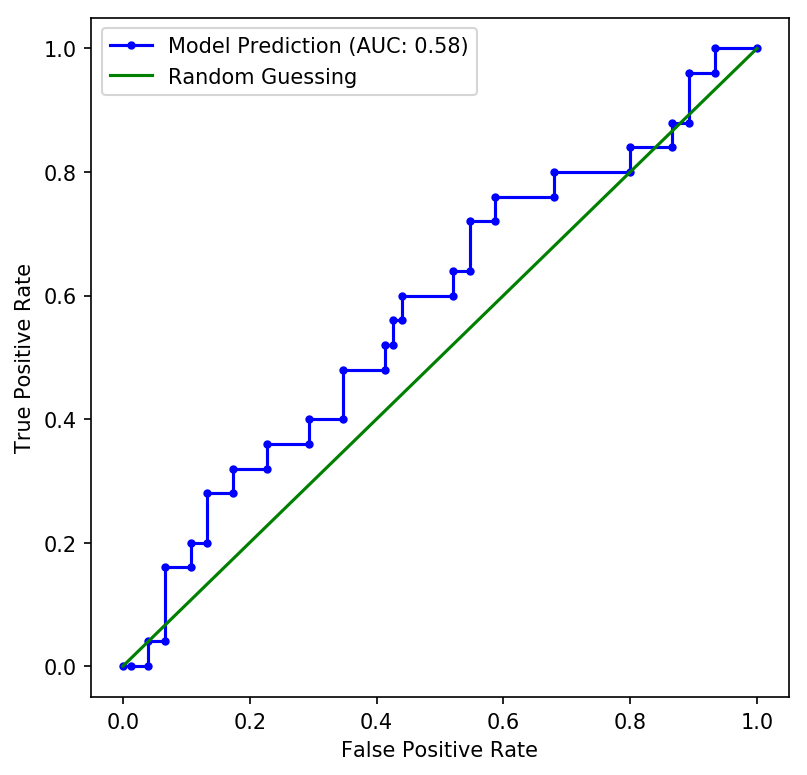

In [18]:
pre = pred_Y[0]

from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pre[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

In [26]:
fig.savefig("roc.png")

In [19]:
from keras.models import model_from_json
# Model to JSON
model_json = model.to_json()
with open("model_project_work.json", "w") as json_file:
    json_file.write(model_json)
# Weights to HDF5
model.save("model_project_work.h5")

In [27]:
os.listdir("../working")

['.ipynb_checkpoints',
 'model_project_work.json',
 '__notebook_source__.ipynb',
 'trainmetrics.png',
 'roc.png',
 'model_project_work.h5']

In [21]:
from keras.models import load_model
new_model = load_model('model_project_work.h5')


In [22]:
pred_Y = new_model.predict(X_test_resh, batch_size = 32, verbose = True)

pred_Y_cat = np.argmax(pred_Y, -1)
#print(pred_Y_cat[0])

test_Y_cat = np.argmax(Y_test, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat[0])))
print(classification_report(test_Y_cat, pred_Y_cat[0]))

100/100 [==============================] - 1s 11ms/step
Accuracy on Test Data: 0.56%
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        75
           1       0.00      0.00      0.00         4
           2       0.21      0.44      0.29        16
           3       0.00      0.00      0.00         1
           4       0.25      0.25      0.25         4

   micro avg       0.56      0.56      0.56       100
   macro avg       0.25      0.27      0.25       100
weighted avg       0.63      0.56      0.59       100



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
